In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO  # YOLOv8 for object detection

Source Domain (Kenai Left Bank):


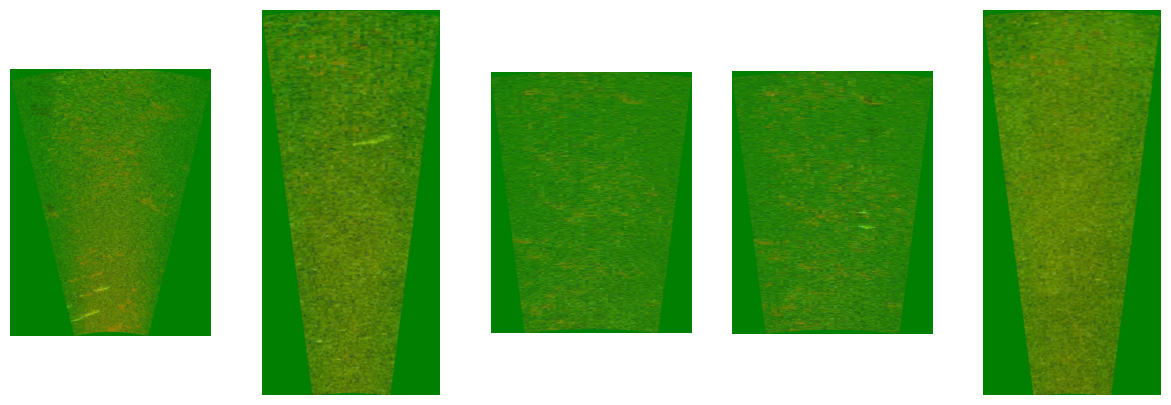

Target Domain (Kenai Channel):


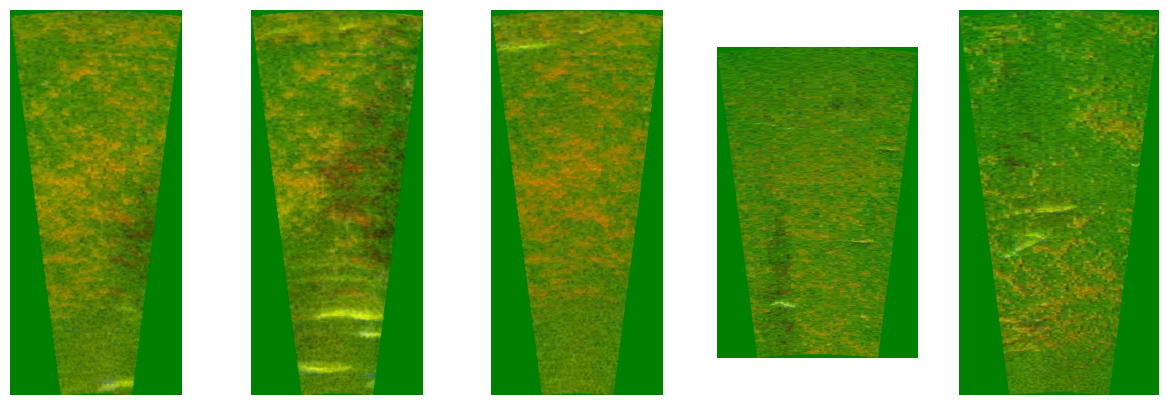

In [7]:
# Define paths
train_images_dir = "/Users/sakuramomoko/Desktop/Fish_counting/cfc_train"
test_images_dir = "/Users/sakuramomoko/Desktop/Fish_counting/cfc_channel_test"

# Load and display some images
def show_sample_images(image_dir, num_samples=5):
    image_files = os.listdir(image_dir)[:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

# Visualize training and test samples
print("Source Domain (Kenai Left Bank):")
show_sample_images(train_images_dir)
print("Target Domain (Kenai Channel):")
show_sample_images(test_images_dir)


In [8]:
import json

# Load COCO annotations
def convert_coco_to_yolo(coco_annotation_path, images_dir, yolo_labels_dir):
    os.makedirs(yolo_labels_dir, exist_ok=True)
    
    with open(coco_annotation_path) as f:
        coco_data = json.load(f)
    
    for img in coco_data["images"]:
        img_id = img["id"]
        img_name = img["file_name"]
        width, height = img["width"], img["height"]
        
        # Find annotations for this image
        annotations = [anno for anno in coco_data["annotations"] if anno["image_id"] == img_id]
        
        yolo_annotations = []
        for anno in annotations:
            x, y, w, h = anno["bbox"]
            x_center, y_center = x + w / 2, y + h / 2
            yolo_annotations.append(f"0 {x_center / width} {y_center / height} {w / width} {h / height}")
        
        # Save to YOLO format
        with open(os.path.join(yolo_labels_dir, img_name.replace(".jpg", ".txt")), "w") as f:
            f.write("\n".join(yolo_annotations))

# Convert annotations
convert_coco_to_yolo("/Users/sakuramomoko/Desktop/Fish_counting/cfc_train.json", train_images_dir, "yolo_labels")


In [11]:
# Define training configuration
model = YOLO("yolov8s.pt")  # Load pre-trained YOLO model

# Train on the source domain dataset
model.train(
    data="yolo_data.yaml",  # YAML file defining train/val split
    epochs=1,
    imgsz=320,
    batch=4,
)


New https://pypi.org/project/ultralytics/8.3.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.74 🚀 Python-3.9.6 torch-2.6.0 CPU (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=yolo_data.yaml, epochs=1, time=None, patience=100, batch=4, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

train: Scanning /Users/sakuramomoko/Desktop/Fish_counting/cfc_train.cache... 0 images, 76619 backgrounds, 0 corrupt: 100%|██████████| 76619/76619 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /Users/sakuramomoko/Desktop/Fish_counting/cfc_train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Scanning /Users/sakuramomoko/Desktop/Fish_counting/cfc_channel_test.cache... 0 images, 26180 backgrounds, 0 corrupt: 100%|██████████| 26180/26180 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /Users/sakuramomoko/Desktop/Fish_counting/cfc_channel_test.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train4/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G          0     0.2521          0          0        320: 100%|██████████| 19155/19155 [2:07:44<00:00,  2.50it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3273/3273 [09:10<00:00,  5.95it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
# Evaluate trained model on target domain (Kenai Channel)
results = model.val(data="target_yolo_data.yaml")


In [ ]:
def generate_pseudo_labels(model, target_images_dir, output_labels_dir):
    os.makedirs(output_labels_dir, exist_ok=True)
    
    for img_file in os.listdir(target_images_dir):
        img_path = os.path.join(target_images_dir, img_file)
        results = model(img_path)
        
        with open(os.path.join(output_labels_dir, img_file.replace(".jpg", ".txt")), "w") as f:
            for result in results:
                for box in result.boxes.data:
                    x_center, y_center, width, height, confidence, class_id = box.tolist()
                    if confidence > 0.8:  # High-confidence detections
                        f.write(f"0 {x_center} {y_center} {width} {height}\n")

# Generate pseudo-labels for target domain
generate_pseudo_labels(model, "path/to/target_images", "path/to/pseudo_labels")


In [ ]:
# Retrain YOLO with pseudo-labeled data
model.train(
    data="path/to/updated_yolo_data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    device="cuda"
)


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.Resize(640, 640),
    ToTensorV2()
])

# Apply augmentation to an image
def augment_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = transform(image=img)["image"]
    return augmented

# Apply to a sample image
augmented_image = augment_image("path/to/sample.jpg")
plt.imshow(augmented_image.permute(1, 2, 0))  # Convert back to matplotlib format
plt.show()


In [ ]:
final_results = model.val(data="path/to/final_target_data.yaml")
print(final_results)
